In [1]:
import os
import numpy as np
#from scipy import signal
import matplotlib.pyplot as plt

(76, 76)


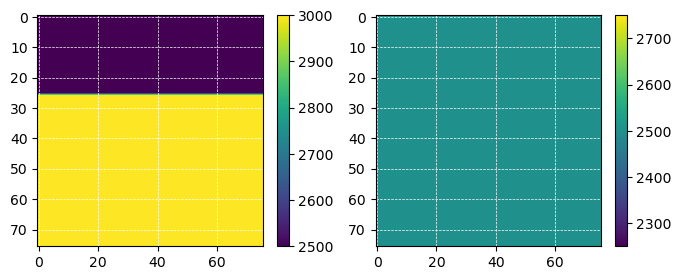

In [48]:
#make model to Xie (2021)
Z1=500; Z2=1000; X=1500
vmin=2500; vmax=3000

h=20  #500/20=25
nz1=26; nz2=50; nz=nz1+nz2; nx=X//h+1
ntr=100

nsnap=51; nzsnap=124; nxsnap=124

#5h=lambda=vmin/fmax
fmax=vmin/(5*h) #
fpeak=fmax/2.5  #10 Hz

#make model
vp=np.zeros((nz,nx)); print(vp.shape)
vp[:nz1,:]=vmin; vp[nz1:,:]=vmax
vp.astype('float32').T.tofile('2layer')

vp[:nz1,:]=vmin; vp[nz1:,:]=vmin
vp.astype('float32').T.tofile('1layer')

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(read('2layer'))
plt.subplot(1,2,2); imshow(read('1layer'))

#on time
dt=0.002  #=half of CFL
nt=500

In [55]:
def read(filename,n=(nx,nz)):
    return np.fromfile(filename,dtype='float32').reshape(n).T

def read_su(filename,n=(ntr,nt)):
    data=read(filename,n=(n[0],int(60+n[1])))
    return data[60:,:]

def read_snap(filename,n=(nsnap,nxsnap,nzsnap),i=26):
    tmp=np.fromfile(filename,dtype='float32').reshape(n).T
    return tmp[:,:,i]

def imshow(data,perc=None,clip=None,clipmin=None,extent=None,cmap='viridis',title=None,grid=True):
    
    if perc==None:
        clipp=[np.amin(data),np.amax(data)]
    else:
        tmp=np.percentile(np.abs(data),q=perc)
        clipp=[-tmp,tmp]
    
    if clip!=None: clipp=clip
    
    if clipmin!=None: clipp[0]=clipmin
    
    plt.imshow(data,vmin=clipp[0],vmax=clipp[1],extent=extent,cmap=cmap,aspect='auto')
    plt.colorbar(location='right')
    plt.grid(visible=grid, axis='both', which='both', color='w', linestyle='--',linewidth=0.5)
    #plt.xlabel(labels[0]); plt.ylabel(labels[1])
    if title!=None: plt.title(title)

def run(app='../../exe/RTM',setup='setup',np=1,nthreads=8,out=None):
    '''
    run(app,setup,np=1,nthreads=8)
    run in a bash env
    ----------------------------
    app      : application/executable to run
    setup    : setup file
    np       : number of MPI processors (default=1)
    nthreads : number of OpenMP threads (default=8)
    
    Caveat: np*nthreads should not exceed total number of CPU cores
    otherwise the running will be very slow
    '''
    
    !echo 'ulimit -s unlimited' > run.sh
    str=f"export OMP_NUM_THREADS={nthreads}"
    !echo $str >> run.sh
    str=f"{app} {setup}"
    !echo $str >> run.sh
    !chmod +x run.sh
    if out==None:
        !./run.sh
    else:
        !./run.sh > {out}
    

def poynting_dotp_gradp(p,p_prev,p_next):
    dotp=(p_next+p_prev-2.*p)/dt**2
    dpdz=np.gradient(p,1./h,axis=0)
    dpdx=np.gradient(p,1./h,axis=1)
    return (dotp*dpdz, dotp*dpdx)
    
def poynting_p_dotp_gradp(p,p_prev,p_next):
    tmp=poynting_dotp_gradp(p,p_prev,p_next)
    return (p*tmp[0], p*tmp[1])

def poynting_p_v(p,vz,vx):
    return (-p*vz, -p*vx)

def gradphi(v,u):
    ph=np.arctan2(v,u)
    dphdz=np.arcsin(np.sin(np.gradient(ph,axis=0)))/h
    dphdx=np.arcsin(np.sin(np.gradient(ph,axis=1)))/h
    return (dphdz,dphdx)

In [43]:
!cat setup_default

MODEL_SIZE              '76 76 1'
MODEL_SPACING           '20 20 1'
FILE_MODEL              '2layer'
MODEL_ATTRIBUTES         vp
FILE_TOPO               'topo'

IS_FREESURFACE          F

ACQUI_GEOMETRY          spread
FS                      '20 760 0'
FR                      '20   0 0'
DR                      '0   20  0'
NR                      76

SCOMP                   p
RCOMP                   p #'p vz'

NT               500
DT               0.002


FPEAK            10
WAVELET_TYPE        'ricker'
T0			0.15
UPDATE_WAVELET		'no'
RDT			0


SNAPSHOT     'p p_prev p_next'
#SNAPSHOT     'p poynz poynx'
#NSNAPSHOT    50


## for RTM ##
FILE_DATA_PREFIX    'results_fwd/dobs_Shot'

JOB           imaging

IF_USE_CHECKPOINT   F



## Poynting vectors

### forward wavefield

In [44]:
!cp setup_default setup
!echo "DIR_OUT     results_obs" >> setup
!echo "SNAPSHOT     'p vz vx'" >> setup
run(app='../../exe/fwd_AC_FDSG_O4_')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/joey/Codes/GitHub/SeisJIMU/Demo/05_Imaging (copy)
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 joey joey 646912 Aug 30 10:41 ../../exe/fwd_AC_FDSG_O4_
 Git Commit: 27d8e8c
 Git Branch: Poynting
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 08/30/2023
System time: 11:33:22
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_obs
 Output directory:results_obs/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D/3D ACoustic propagation
1st-order Velocity-Stress formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.606(for 2D) 

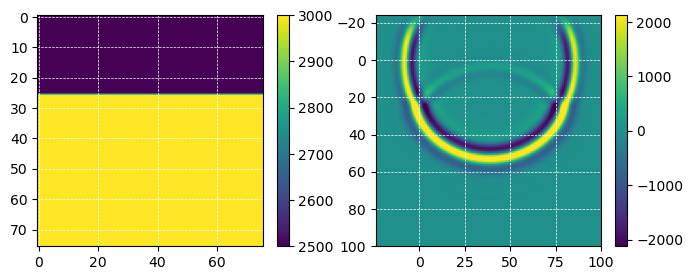

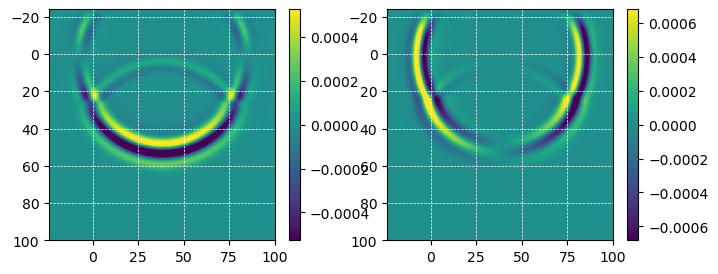

In [56]:
## plot
plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(read('2layer'))

p =read_snap('results_obs/snap_fld_u%p')
vz=read_snap('results_obs/snap_fld_u%vz')
vx=read_snap('results_obs/snap_fld_u%vx')

plt.subplot(1,2,2); imshow(p,perc=98,extent=(-24,100,100,-24))

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(vz,perc=98,extent=(-24,100,100,-24))
plt.subplot(1,2,2); imshow(vx,perc=98,extent=(-24,100,100,-24))

$\vec{s} = \vec{\vec{\sigma}}\cdot\vec{v} = -P\vec{v} $

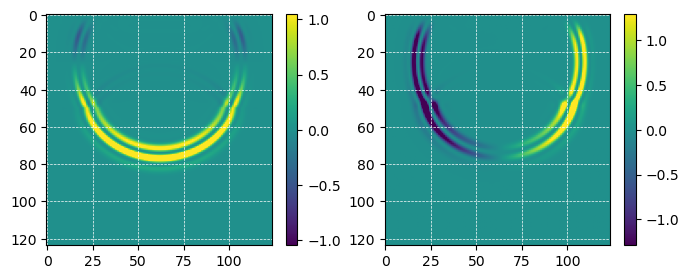

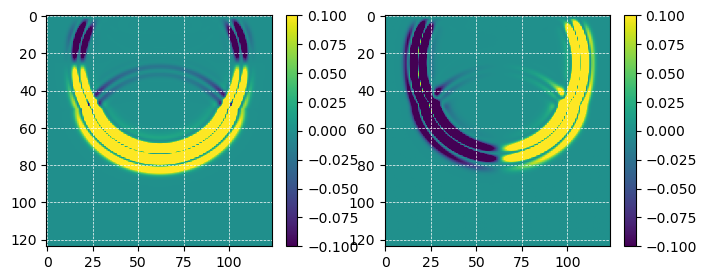

In [57]:
poynz,poynx = poynting_p_v(p,vz,vx)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(poynz,perc=98)
plt.subplot(1,2,2); imshow(poynx,perc=98)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(poynz,clip=[-0.1,0.1])
plt.subplot(1,2,2); imshow(poynx,clip=[-0.1,0.1])

### forward wavefield AC2nd

In [8]:
!cp setup_default setup
!echo "DIR_OUT     results_obs_AC2nd" >> setup
run(app='../../exe/fwd_AC2nd_FDSG_O4_')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/joey/Codes/GitHub/SeisJIMU/Demo/05_Imaging (copy)
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 joey joey 605568 Aug 30 10:22 ../../exe/fwd_AC2nd_FDSG_O4_
 Git Commit: 27d8e8c
 Git Branch: Poynting
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 08/30/2023
System time: 10:43:14
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_obs_AC2nd
 Output directory:results_obs_AC2nd/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D/3D Acoustic propagation
2nd-order Pressure formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.5*Vm

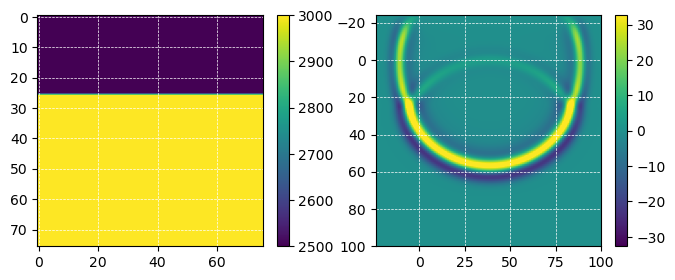

In [9]:
## plot
plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(read('2layer'))

p     =read_snap('results_obs_AC2nd/snap_fld_u%p')
p_prev=read_snap('results_obs_AC2nd/snap_fld_u%p_prev')
p_next=read_snap('results_obs_AC2nd/snap_fld_u%p_next')

plt.subplot(1,2,2); imshow(p,perc=98,extent=(-24,100,100,-24))

#### $\vec{s} := \dot{P} \nabla{P} $

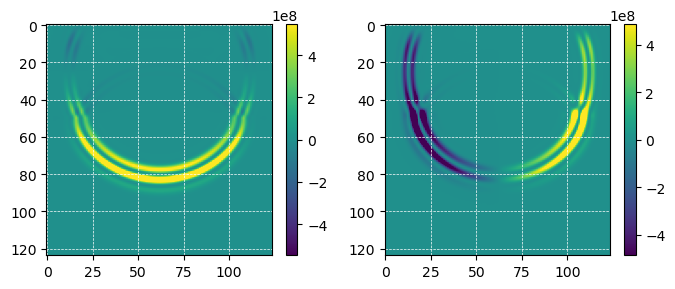

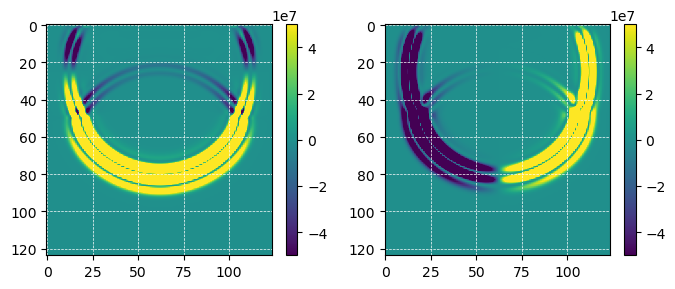

In [10]:
poynz,poynx = poynting_dotp_gradp(p,p_prev,p_next)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(poynz,perc=98)
plt.subplot(1,2,2); imshow(poynx,perc=98)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(poynz,clip=[-5e7,5e7])
plt.subplot(1,2,2); imshow(poynx,clip=[-5e7,5e7])

#### $\vec{s} := P \dot{P} \nabla{P} $  (this should be wrong)

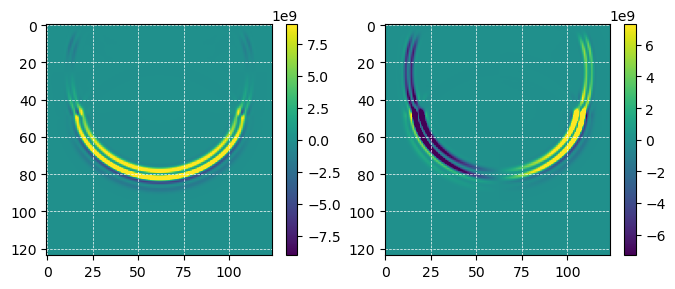

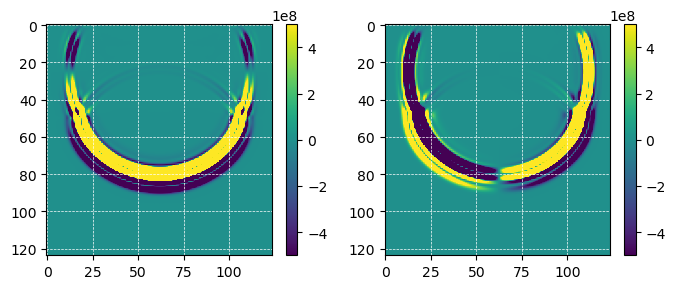

In [11]:
poynz,poynx = poynting_p_dotp_gradp(p,p_prev,p_next)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(poynz,perc=98)
plt.subplot(1,2,2); imshow(poynx,perc=98)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(poynz,clip=[-5e8,5e8])
plt.subplot(1,2,2); imshow(poynx,clip=[-5e8,5e8])

$\vec{s} = E^2\nabla\phi $

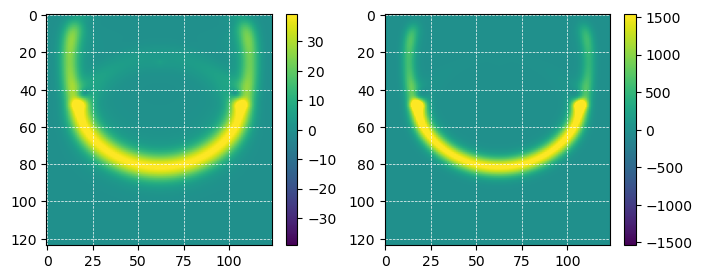

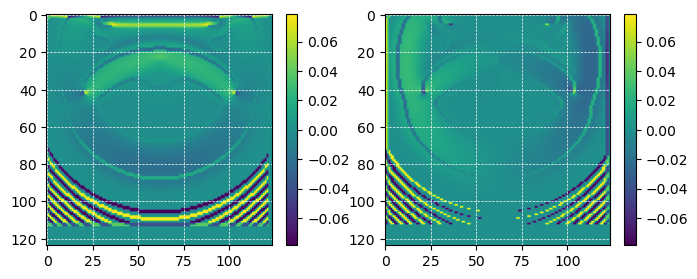

In [12]:
u=read_snap('results_obs_AC2nd/snap_fld_u%p')
v=read_snap('results_obs_AC2nd/snap_fld_v%p')

E=np.sqrt(u**2+v**2)

dphdz,dphdx=gradphi(v,u)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(E,perc=98)
plt.subplot(1,2,2); imshow(E**2,perc=98)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(dphdz,perc=98)
plt.subplot(1,2,2); imshow(dphdx,perc=98)

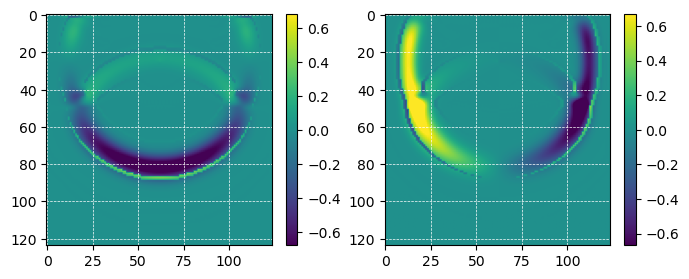

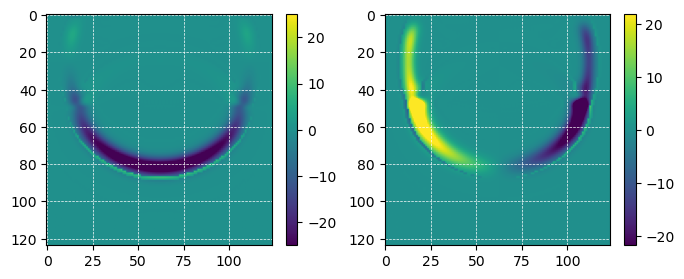

In [13]:
poynz=E*dphdz
poynx=E*dphdx

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(poynz,perc=98)
plt.subplot(1,2,2); imshow(poynx,perc=98)

poynz=E**2 *dphdz
poynx=E**2 *dphdx

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(poynz,perc=98)
plt.subplot(1,2,2); imshow(poynx,perc=98)

np.gradient on phi is causing small artifacts near the wavefront,
so in the Poynting vector plots.

Below, try compute gradphi in fortran.

In [14]:
!gfortran compute_E_ph.f90
!echo "'./results_obs_AC2nd/snap_fld_u%p' './results_obs_AC2nd/snap_fld_v%p' 47" > par
!./a.out < par

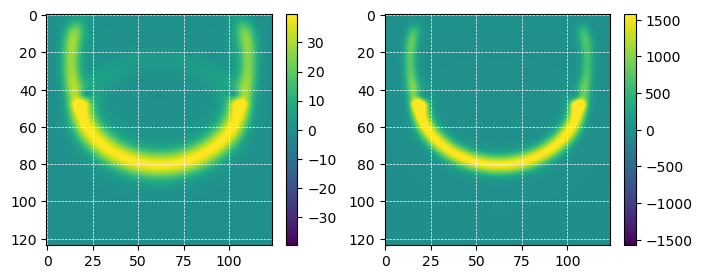

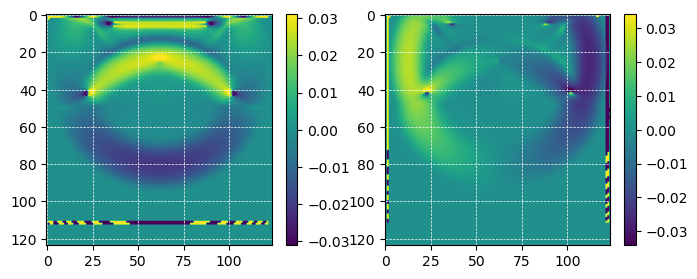

In [15]:
## plot
plt.figure(figsize=(8,3))
E=read('E',n=(nxsnap,nzsnap))
plt.subplot(1,2,1); imshow(E,perc=98)
plt.subplot(1,2,2); imshow(E**2,perc=98)

plt.figure(figsize=(8,3))
dph_dz=read('dph_dz',n=(nxsnap,nzsnap))
dph_dx=read('dph_dx',n=(nxsnap,nzsnap))
plt.subplot(1,2,1); imshow(dph_dz,perc=98)
plt.subplot(1,2,2); imshow(dph_dx,perc=98)

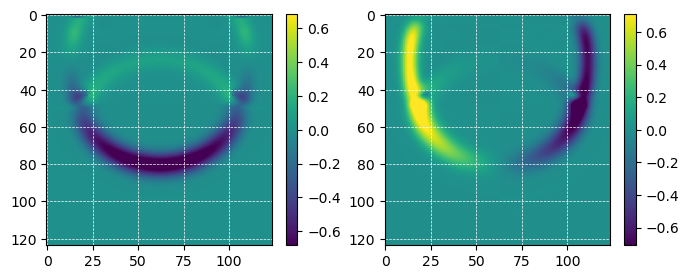

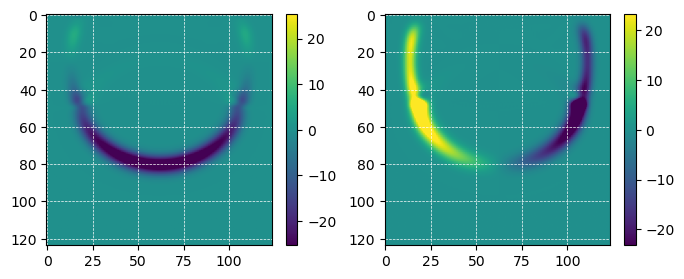

In [16]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(E*dph_dz,perc=98)
plt.subplot(1,2,2); imshow(E*dph_dx,perc=98)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(E**2*dph_dz,perc=98)
plt.subplot(1,2,2); imshow(E**2*dph_dx,perc=98)

## Back & forward scattering images

### RTM

$\vec{s} = \vec{\vec{\sigma}}\cdot\vec{v} = -P\vec{v} $

In [64]:
!cp setup_default setup
!echo "FILE_MODEL   1layer" >>setup
!echo "FILE_DATA_PREFIX    'results_obs/dsyn_Shot'" >>setup
!echo "SNAPSHOT     'p poynz poynx'" >> setup
!echo "DIR_OUT     results_rtm" >> setup
run(app='../../exe/rtm_AC_FDSG_O4')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/joey/Codes/GitHub/SeisJIMU/Demo/05_Imaging (copy)
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 joey joey 2400072 Aug 30 11:48 ../../exe/rtm_AC_FDSG_O4
 Git Commit: 27d8e8c
 Git Branch: Poynting
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 08/30/2023
System time: 11:49:03
System timezone: +03:00
                        
       WELCOME TO SeisJIMU RTM        
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_rtm
 Output directory:results_rtm/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D/3D ACoustic propagation
1st-order Velocity-Stress formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.606(for 2D) 

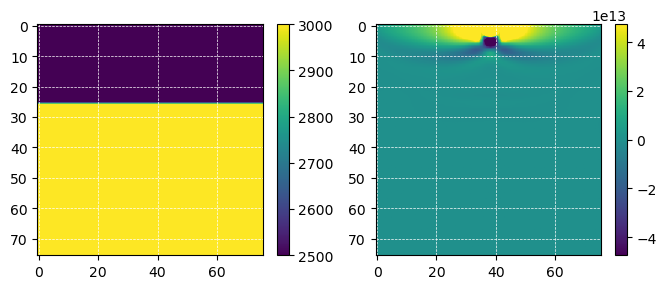

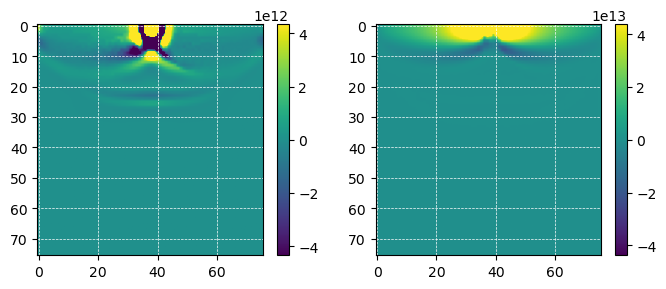

In [65]:
images=read('results_rtm/correlate_image',n=(3*nx,nz))
ipp=images[:,:nx]; ibksc=images[:,nx:2*nx]; ifwsc=images[:,2*nx:]; del images

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(read('2layer'))
plt.subplot(1,2,2); imshow(ipp,perc=98)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(ibksc,perc=98)
plt.subplot(1,2,2); imshow(ifwsc,perc=98)

### RTM w/ AC2nd 
$\vec{s} = E^2\nabla\phi $

In [58]:
!cp setup_default setup
!echo "FILE_MODEL   1layer" >>setup
!echo "FILE_DATA_PREFIX    'results_obs_AC2nd/dsyn_Shot'" >>setup
!echo "SNAPSHOT     'p poynz poynx'" >> setup
!echo "DIR_OUT     results_rtm_AC2nd" >> setup
run(app='../../exe/rtm_AC2nd_FDSG_O4')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/joey/Codes/GitHub/SeisJIMU/Demo/05_Imaging (copy)
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 joey joey 2227616 Aug 30 11:11 ../../exe/rtm_AC2nd_FDSG_O4
 Git Commit: 27d8e8c
 Git Branch: Poynting
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 08/30/2023
System time: 11:35:18
System timezone: +03:00
                        
       WELCOME TO SeisJIMU RTM        
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_rtm_AC2nd
 Output directory:results_rtm_AC2nd/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D/3D Acoustic propagation
2nd-order Pressure formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.5*Vm

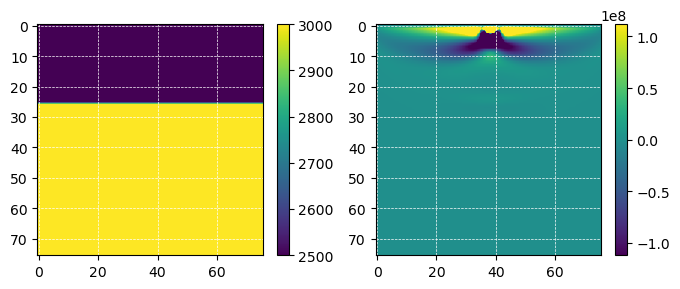

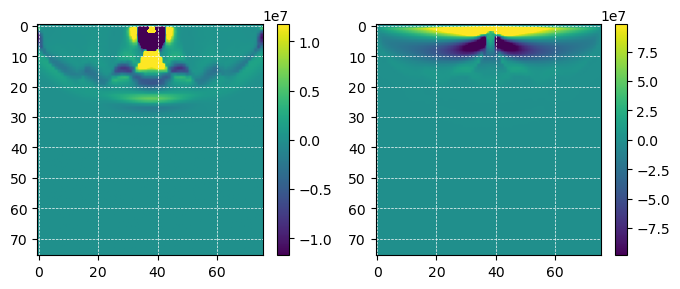

In [59]:
images=read('results_rtm_AC2nd/correlate_image',n=(3*nx,nz))
ipp=images[:,:nx]; ibksc=images[:,nx:2*nx]; ifwsc=images[:,2*nx:]; del images

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(read('2layer'))
plt.subplot(1,2,2); imshow(ipp,perc=98)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(ibksc,perc=98)
plt.subplot(1,2,2); imshow(ifwsc,perc=98)